# Using Predictive Analytics to Predict Delays in Maritime Container Shipping

In [1]:
%matplotlib inline

**Import Libraries**

In [2]:
import csv
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import pylab 
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
#https://github.com/pandas-dev/pandas/issues/8509
warnings.filterwarnings('ignore', 'numpy not_equal will not check object identity in the future')

from sklearn.model_selection import train_test_split

In [3]:
#Open the dataframe
df = pd.read_pickle('D:/CUNY Files/capstone/code files/2014_data_LA_SH_V2.pkl')

** Consolidate observations by identifier ** 

description text won't be analyzed for this as the added complexity is beyond the scope of this analysis

In [4]:
#add a combined shipper - consigner column in case the combinations of these makes a difference
df['shipper_consigner'] = df.shipper_party_name.str.cat(df.consignee_name.astype(str), sep='-')

In [5]:
list(df)

['identifier',
 'trade_update_date',
 'run_date',
 'vessel_name_orig',
 'port_of_unlading',
 'estimated_arrival_date',
 'foreign_port_of_lading',
 'record_status_indicator',
 'place_of_receipt',
 'port_of_destination',
 'foreign_port_of_destination',
 'actual_arrival_date',
 'consignee_name',
 'shipper_party_name',
 'container_number',
 'description_sequence_number',
 'piece_count',
 'description_text',
 'carrier',
 'day_of_week_est',
 'day_of_week_act',
 'month_est',
 'month_act',
 'delay_days',
 'vessel_name',
 'shipper_consigner']

In [6]:
#check that there is a piece count for all observations
len(df),len(df.piece_count >= 1)

(658583, 658583)

In [7]:
#description sequence number shows order of shipments for the same consigner-shipper pair
df[df.identifier == 2014102195].iloc[:,0:17]

,identifier,trade_update_date,run_date,vessel_name_orig,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,foreign_port_of_destination,actual_arrival_date,consignee_name,shipper_party_name,container_number,description_sequence_number,piece_count
9052012,2014102195,2014-04-22,2014-10-21,CSCL WINTER,"Los Angeles, California",2014-05-10,"Shanghai ,China (Mainland)",Amended,SHANGHAI,NaN,NaN,2014-05-12,GENESCO INC,CHANGSHU ARTISAN LEATHER GOODS,CCLU4569975,1,3
9052013,2014102195,2014-04-22,2014-10-21,CSCL WINTER,"Los Angeles, California",2014-05-10,"Shanghai ,China (Mainland)",Amended,SHANGHAI,NaN,NaN,2014-05-12,GENESCO INC,CHANGSHU ARTISAN LEATHER GOODS,CCLU4569975,2,2
9052014,2014102195,2014-04-22,2014-10-21,CSCL WINTER,"Los Angeles, California",2014-05-10,"Shanghai ,China (Mainland)",Amended,SHANGHAI,NaN,NaN,2014-05-12,GENESCO INC,CHANGSHU ARTISAN LEATHER GOODS,CCLU4569975,3,3
9052015,2014102195,2014-04-22,2014-10-21,CSCL WINTER,"Los Angeles, California",2014-05-10,"Shanghai ,China (Mainland)",Amended,SHANGHAI,NaN,NaN,2014-05-12,GENESCO INC,CHANGSHU ARTISAN LEATHER GOODS,CCLU4569975,4,2
9052016,2014102195,2014-04-22,2014-10-21,CSCL WINTER,"Los Angeles, California",2014-05-10,"Shanghai ,China (Mainland)",Amended,SHANGHAI,NaN,NaN,2014-05-12,GENESCO INC,CHANGSHU ARTISAN LEATHER GOODS,CCLU4569975,5,3
9052017,2014102195,2014-04-22,2014-10-21,CSCL WINTER,"Los Angeles, California",2014-05-10,"Shanghai ,China (Mainland)",Amended,SHANGHAI,NaN,NaN,2014-05-12,GENESCO INC,CHANGSHU ARTISAN LEATHER GOODS,CCLU4569975,6,2


Add a 'day of month' and then 'half month' field that identifies whether is the first half of the month or the second half (divide all months by the 15th of the month), this will be used later to consolidate by vessel

In [8]:
#add day of month
df['day_of_month_est'] = df.estimated_arrival_date.dt.day

In [9]:
#add first half of month or second (split on day 15 of the month - will simulate voyages with vessel by half month)
df['half_month_est'] = np.where(df.day_of_month_est <= 15, 1, 2)

In [10]:
df.head()

,identifier,trade_update_date,run_date,vessel_name_orig,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,...,carrier,day_of_week_est,day_of_week_act,month_est,month_act,delay_days,vessel_name,shipper_consigner,day_of_month_est,half_month_est
74,2014082163454,2014-07-31,2014-08-21,CSCL SUMMER,"Los Angeles, California",2014-08-17,"Shanghai ,China (Mainland)",Amended,SHANGHAI,NaN,...,CSCL,6,6,8,8,0,CSCL SUMMER,"HON HAI PRECISION INDUSTRY CO.,LTD.-INFOCUS CO...",17,2
87,2014082165149,2014-08-13,2014-08-21,NYK TERRA,"Los Angeles, California",2014-08-18,"Shanghai ,China (Mainland)",New,"SHANGHAI, CN","Laredo, Texas",...,NYK,0,0,8,8,0,NYK TERRA,"SHAANXI SIRUI INDUSTRIES CO.,LTD.-GE MRS",18,2
88,2014082165166,2014-08-13,2014-08-21,NYK TERRA,"Los Angeles, California",2014-08-18,"Shanghai ,China (Mainland)",New,"SHANGHAI, CN","Atlanta, Georgia",...,NYK,0,0,8,8,0,NYK TERRA,"KUEHNE & NAGEL LIMITED-KUEHNE + NAGEL, INC.",18,2
89,2014082165166,2014-08-13,2014-08-21,NYK TERRA,"Los Angeles, California",2014-08-18,"Shanghai ,China (Mainland)",New,"SHANGHAI, CN","Atlanta, Georgia",...,NYK,0,0,8,8,0,NYK TERRA,"KUEHNE & NAGEL LIMITED-KUEHNE + NAGEL, INC.",18,2
90,2014082165204,2014-07-31,2014-08-21,NYK TERRA,"Los Angeles, California",2014-08-18,"Shanghai ,China (Mainland)",New,"SHANGHAI, CN","Otay Mesa Station, California",...,NYK,0,0,8,8,0,NYK TERRA,ZHANGJIAGANG SUNSHINE CORPORATION-ATE PRO TOOLS,18,2


Set grouby fields to group by identifier

In [11]:
#set up the groupby and count fields
df_count = df[['identifier','trade_update_date','run_date','vessel_name_orig','vessel_name','carrier',
          'port_of_unlading','estimated_arrival_date','day_of_month_est','half_month_est','actual_arrival_date',
          'foreign_port_of_lading','record_status_indicator','place_of_receipt','day_of_week_est',
          'day_of_week_act','month_est','month_act','delay_days','consignee_name','shipper_party_name',
          'shipper_consigner','container_number']]

df_sum = df[['identifier','trade_update_date','run_date','vessel_name_orig','vessel_name','carrier',
          'port_of_unlading','estimated_arrival_date','day_of_month_est','half_month_est','actual_arrival_date',
          'foreign_port_of_lading','record_status_indicator','place_of_receipt','day_of_week_est',
          'day_of_week_act','month_est','month_act','delay_days','piece_count']]

id_groupby_fields = ['identifier','trade_update_date','run_date','vessel_name_orig','vessel_name','carrier',
                     'port_of_unlading','estimated_arrival_date','day_of_month_est','half_month_est',
                     'actual_arrival_date','foreign_port_of_lading','record_status_indicator',
                     'place_of_receipt','day_of_week_est','day_of_week_act','month_est','month_act','delay_days']

In [12]:
#Get the unique count
df2 = df_count.groupby(id_groupby_fields,as_index=False).agg(['nunique'])

In [13]:
#get the sum of the piece count as well as number of shipments
df2_sum = df_sum.groupby(id_groupby_fields,as_index=False).agg(['sum','count'])

In [14]:
#reformat columns
df2.columns = ['_'.join(tup).rstrip('_') for tup in df2.columns.values]
df2.reset_index(col_level=1,inplace = True)

df2_sum.columns = ['_'.join(tup).rstrip('_') for tup in df2_sum.columns.values]
df2_sum.reset_index(col_level=1,inplace = True)


In [15]:
df2.head()

,identifier,trade_update_date,run_date,vessel_name_orig,vessel_name,carrier,port_of_unlading,estimated_arrival_date,day_of_month_est,half_month_est,...,place_of_receipt,day_of_week_est,day_of_week_act,month_est,month_act,delay_days,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique
0,201406038,2014-01-16,2014-06-03,HANJIN KOREA,HANJIN KOREA,HANJIN,"Long Beach, California",2014-02-05,5,1,...,SHANGHAI,2,3,2,2,1,0,0,0,1
1,201406058,2014-01-30,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,18,2,...,SHANGHAI,1,5,2,2,4,1,1,1,1
2,201406059,2014-01-28,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,18,2,...,SHANGHAI,1,5,2,2,4,0,0,0,1
3,201411248,2014-05-08,2014-11-24,CSCL SUMMER,CSCL SUMMER,CSCL,"Los Angeles, California",2014-05-25,25,2,...,SHANGHAI,6,6,5,5,0,1,1,1,1
4,201412018,2014-04-23,2014-12-01,HANJIN CHINA,HANJIN CHINA,HANJIN,"Los Angeles, California",2014-05-08,8,1,...,"JIANGYIN, CHINA",3,3,5,5,7,1,1,1,14


In [16]:
len(df2)

374871

In [17]:
df2_sum.head()

,identifier,trade_update_date,run_date,vessel_name_orig,vessel_name,carrier,port_of_unlading,estimated_arrival_date,day_of_month_est,half_month_est,...,foreign_port_of_lading,record_status_indicator,place_of_receipt,day_of_week_est,day_of_week_act,month_est,month_act,delay_days,piece_count_sum,piece_count_count
0,201406038,2014-01-16,2014-06-03,HANJIN KOREA,HANJIN KOREA,HANJIN,"Long Beach, California",2014-02-05,5,1,...,"Shanghai ,China (Mainland)",Amended,SHANGHAI,2,3,2,2,1,126,1
1,201406058,2014-01-30,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,18,2,...,"Shanghai ,China (Mainland)",Amended,SHANGHAI,1,5,2,2,4,1000,1
2,201406059,2014-01-28,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,18,2,...,"Shanghai ,China (Mainland)",Amended,SHANGHAI,1,5,2,2,4,2079,1
3,201411248,2014-05-08,2014-11-24,CSCL SUMMER,CSCL SUMMER,CSCL,"Los Angeles, California",2014-05-25,25,2,...,"Shanghai ,China (Mainland)",Amended,SHANGHAI,6,6,5,5,0,14,1
4,201412018,2014-04-23,2014-12-01,HANJIN CHINA,HANJIN CHINA,HANJIN,"Los Angeles, California",2014-05-08,8,1,...,"Shanghai ,China (Mainland)",Amended,"JIANGYIN, CHINA",3,3,5,5,7,196,14


In [18]:
#change the column header for piece_count_count to shipment_count
df2_sum=df2_sum.rename(columns = {'piece_count_count':'shipment_count'})

In [19]:
#merge the sum into df2
df2 = df2.merge(df2_sum, on = id_groupby_fields, how = 'left')

In [20]:
#compare groupby dataframe to original
df2.shape, df.shape

((374871, 25), (658583, 28))

In [21]:
df2.head()

,identifier,trade_update_date,run_date,vessel_name_orig,vessel_name,carrier,port_of_unlading,estimated_arrival_date,day_of_month_est,half_month_est,...,day_of_week_act,month_est,month_act,delay_days,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,piece_count_sum,shipment_count
0,201406038,2014-01-16,2014-06-03,HANJIN KOREA,HANJIN KOREA,HANJIN,"Long Beach, California",2014-02-05,5,1,...,3,2,2,1,0,0,0,1,126,1
1,201406058,2014-01-30,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,18,2,...,5,2,2,4,1,1,1,1,1000,1
2,201406059,2014-01-28,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,18,2,...,5,2,2,4,0,0,0,1,2079,1
3,201411248,2014-05-08,2014-11-24,CSCL SUMMER,CSCL SUMMER,CSCL,"Los Angeles, California",2014-05-25,25,2,...,6,5,5,0,1,1,1,1,14,1
4,201412018,2014-04-23,2014-12-01,HANJIN CHINA,HANJIN CHINA,HANJIN,"Los Angeles, California",2014-05-08,8,1,...,3,5,5,7,1,1,1,14,196,14


** Review the distribution of delay days **

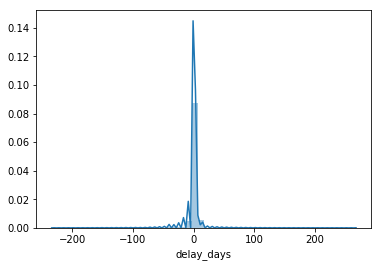

In [22]:
sns.distplot(df2.delay_days)

In [23]:
#get summary statistics on delay days
df2.delay_days.describe()

count    374871.000000
mean          0.663415
std           6.225818
min        -234.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         268.000000
Name: delay_days, dtype: float64

** Identify and evaluate outliers **   
  
Use Extreme Value Analysis

In [24]:
#three standard deviations from the mean
print(df2.delay_days.mean() + (df2.delay_days.std() * 3))
print(df2.delay_days.mean() - (df2.delay_days.std() * 3))

19.34086777461674
-18.014038011845017


In [25]:
#two standard deviations from the mean
print(df2.delay_days.mean() + (df2.delay_days.std() * 2))
print(df2.delay_days.mean() - (df2.delay_days.std() * 2))

13.115050143539783
-11.788220380768056


In [26]:
#Evaluate % of observations more than 2 standard deviations from the mean
len(df[(df.delay_days < -12) | (df.delay_days > 13)]) / (len(df) * 1.0)

0.02480325183006546

In [27]:
#get dataframe of outliers
df2_outs = df2[(df2.delay_days < -12) | (df2.delay_days > 13)].sort_values('delay_days')

In [28]:
#View outliers
df2_outs.head()

,identifier,trade_update_date,run_date,vessel_name_orig,vessel_name,carrier,port_of_unlading,estimated_arrival_date,day_of_month_est,half_month_est,...,day_of_week_act,month_est,month_act,delay_days,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,piece_count_sum,shipment_count
32430,2014011136313,2013-12-24,2014-01-11,SUN ROAD,SUN ROAD,SUN,"Long Beach, California",2014-09-01,1,1,...,4,9,1,-234,0,0,0,1,380,1
374791,20140812163376,2014-08-07,2014-08-12,CSCL AUTUMN,CSCL AUTUMN,CSCL,"Los Angeles, California",2014-08-23,23,2,...,0,8,2,-194,0,0,0,1,840,1
374792,20140812163396,2014-08-07,2014-08-12,CSCL AUTUMN,CSCL AUTUMN,CSCL,"Los Angeles, California",2014-08-23,23,2,...,0,8,2,-194,1,1,1,1,220,1
374801,20140812164010,2014-08-07,2014-08-12,CSCL AUTUMN,CSCL AUTUMN,CSCL,"Los Angeles, California",2014-08-23,23,2,...,0,8,2,-194,1,1,1,1,3,1
374802,20140812164014,2014-08-07,2014-08-12,CSCL AUTUMN,CSCL AUTUMN,CSCL,"Los Angeles, California",2014-08-23,23,2,...,0,8,2,-194,0,0,0,1,300,1


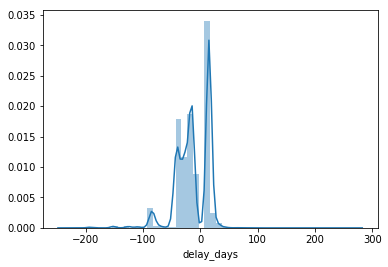

In [29]:
#view the distribution of outliers
sns.distplot(df2_outs.delay_days)

Many of the outliers are observations where the actual arrival date is prior to the estimated arrival date, which are more likely to be data errors or situations or may represent an extreme event that will skew the model.

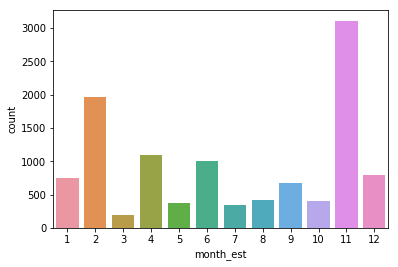

In [30]:
#get the number of outliers by month to see if there are patterns
sns.countplot(x="month_est", data=df2_outs);

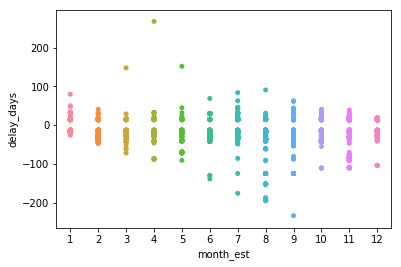

In [31]:
#view outlier scatter by month
sns.stripplot(x="month_est", y="delay_days", data=df2_outs)

There are more outliers in some months than others, particularly February and November, but as the the scatter shows the majority are negative values (actual arrival much earlier than estimated), which is more likely to imply errors in the data

In [32]:
#number of total carriers vs those that are part of the outliers
len(df2.carrier.unique()), len(df2_outs.carrier.unique())

(141, 65)

In [33]:
#number of outliers, % that are outliers
print(df2.shape, df2_outs.shape)
print(round(len(df2_outs)/(len(df2)*1.0),4))

(374871, 25) (11121, 25)
0.0297


Using the number of identifiers per half month by vessel as the denominator and the number of identifiers with a particular estimated arrival dates during that half month for a vessel as the numerator, get a weighted average of the estimated arrival date and then the actual arrival dates connected to that half month.  The assumption is that the estimate may be more accurate and less likely to be an error if more observations (by identifier) contain the same date.

** Consolidate by vessel name **  
  
Method:  group by vessel by half month as an approximation to vessel voyages  
  
a.  group by vessel, month, and half month and for the already grouped identifiers get:
1. redo groupings for the consignee, shipper, shipper-consigner, container_number by vessel by half month (need unique for month and half month
2. the sum of remaining counts and sums except those in 1
3. the sum of identifiers for each half month
  
b.  group df2 by vessel, half month, and day of month:
1. get the count of identifiers
2. bring in the count of identifiers from a3, add column with a weighted day of month (weighted by percent of half month identifiers that have that date as the estimated arrival date)
3. group by vessel, month, and half month and get the weighted average estimated arrival day 
4. get average of actual arrival dates and get weighted average delay days
5. bring all sum and count fields in - uses this new weighted average dataset to predict delays by vessel by voyage (half month + vessel name)

a1

In [34]:
#set up the groupby and count fields
df_count2 = df[['vessel_name','half_month_est',
                'month_est','consignee_name','shipper_party_name',
                'shipper_consigner','container_number']]

id_groupby_fields2 = ['vessel_name','month_est','half_month_est']                      

In [35]:
#Get the unique count
df2_a1 = df_count2.groupby(id_groupby_fields2,as_index=False).agg(['nunique'])
#reformat columns
df2_a1.columns = ['_'.join(tup).rstrip('_') for tup in df2_a1.columns.values]
df2_a1.reset_index(col_level=1,inplace = True)

In [36]:
df2_a1.head()

,vessel_name,month_est,half_month_est,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique
0,9294800,5,2,1,1,1,1
1,9337937,2,1,1,1,1,11
2,9337937,2,2,1,1,1,1
3,9364992,9,1,1,1,1,1
4,9364992,10,2,2,2,2,2


a2

In [37]:
#set up the groupby and count fields
df_sum3 = df2[['vessel_name','month_est','half_month_est',
              'piece_count_sum','shipment_count']]

id_groupby_fields3 = ['vessel_name','month_est','half_month_est']

In [38]:
#Get the sum based on grouped identifier counts
df2_a2 = df_sum3.groupby(id_groupby_fields3,as_index=False).agg(['sum'])
#reformat columns
df2_a2.columns = ['_'.join(tup).rstrip('_') for tup in df2_a2.columns.values]
df2_a2.reset_index(col_level=1,inplace = True)

In [39]:
df2_a2.head()

,vessel_name,month_est,half_month_est,piece_count_sum_sum,shipment_count_sum
0,9294800,5,2,1,1
1,9337937,2,1,5718,11
2,9337937,2,2,1141,1
3,9364992,9,1,3,1
4,9364992,10,2,1136,2


a3

In [40]:
#get the count of identifiers by half month
df_count_a3 = df2[['vessel_name','month_est','half_month_est',
              'identifier']]

id_groupby_fields_a3 = ['vessel_name','month_est','half_month_est']

In [41]:
#Get the sum based on grouped identifier counts
df2_a3 = df_count_a3.groupby(id_groupby_fields_a3,as_index=False).agg(['count'])
#reformat columns
df2_a3.columns = ['_'.join(tup).rstrip('_') for tup in df2_a3.columns.values]
df2_a3.reset_index(col_level=1,inplace = True)

In [42]:
df2_a3.head()

,vessel_name,month_est,half_month_est,identifier_count
0,9294800,5,2,1
1,9337937,2,1,2
2,9337937,2,2,1
3,9364992,9,1,1
4,9364992,10,2,2


b1

In [43]:
#set up the groupby and count fields
df_count4 = df2[['vessel_name','month_est','half_month_est','day_of_month_est',
                  'estimated_arrival_date']]

id_groupby_fields4 = ['vessel_name','month_est','half_month_est','day_of_month_est']

In [44]:
#Get the count of identifiers based on vessel, month, half month and estimated arrival dates
df2_b1 = df_count4.groupby(id_groupby_fields4,as_index=False).agg(['count'])
#reformat columns
df2_b1.columns = ['_'.join(tup).rstrip('_') for tup in df2_b1.columns.values]
df2_b1.reset_index(col_level=1,inplace = True)

b2

In [45]:
df2_b1.head()

,vessel_name,month_est,half_month_est,day_of_month_est,estimated_arrival_date_count
0,9294800,5,2,25,1
1,9337937,2,1,14,1
2,9337937,2,1,15,1
3,9337937,2,2,16,1
4,9364992,9,1,14,1


In [46]:
df2_b2 = df2_b1.merge(df2_a3, on = ['vessel_name','month_est','half_month_est'], how = 'left')

In [47]:
df2_b2.rename(columns={'estimated_arrival_date_count': 'day_of_month_count', 'identifier_count': 'half_month_count'}, inplace=True)
df2_b2.head()

,vessel_name,month_est,half_month_est,day_of_month_est,day_of_month_count,half_month_count
0,9294800,5,2,25,1,1
1,9337937,2,1,14,1,2
2,9337937,2,1,15,1,2
3,9337937,2,2,16,1,1
4,9364992,9,1,14,1,1


In [48]:
#weight day of month by percent of observations for the half month that are on that day
df2_b2['day_of_month_weighted'] = round(df2_b2.day_of_month_count/
                                        (df2_b2.half_month_count * 1.0) * df2_b2.day_of_month_est,4)

In [49]:
df2_b2.head()

,vessel_name,month_est,half_month_est,day_of_month_est,day_of_month_count,half_month_count,day_of_month_weighted
0,9294800,5,2,25,1,1,25.0
1,9337937,2,1,14,1,2,7.0
2,9337937,2,1,15,1,2,7.5
3,9337937,2,2,16,1,1,16.0
4,9364992,9,1,14,1,1,14.0


b3

In [50]:
#set up the groupby and count fields
df_sum5 = df2_b2[['vessel_name','month_est','half_month_est','day_of_month_weighted']]

id_groupby_fields5 = ['vessel_name','month_est','half_month_est']

In [51]:
#Get the max based on count of identifiers by day of month (by vessel by half month)
df2_b3 = df_sum5.groupby(id_groupby_fields5,as_index=False).agg(['sum'])
#reformat columns
df2_b3.columns = ['_'.join(tup).rstrip('_') for tup in df2_b3.columns.values]
df2_b3.reset_index(col_level=1,inplace = True)

In [52]:
df2_b3['day_of_month_weighted_sum'] = df2_b3.day_of_month_weighted_sum.round(0).astype(int)
df2_b3.rename(columns={'day_of_month_weighted_sum': 'day_of_month_est_ws'}, inplace=True)

In [53]:
df2_b3.head()

,vessel_name,month_est,half_month_est,day_of_month_est_ws
0,9294800,5,2,25
1,9337937,2,1,14
2,9337937,2,2,16
3,9364992,9,1,14
4,9364992,10,2,17


b4

In [54]:
df2_b3.shape

(1900, 4)

In [55]:
#get actual arrival dates by vessel, month, and half month - count, weighted avg and groupby ??
#can use half_month_est identifier count from above
#actual not always in the same month as estimated - how to deal with this???
#have to keep it paired and somehow weighted average the dates
#turn est back into date and calc days between est and act then weight that, then sum to get delay days
df2_b4 = df2[['vessel_name','month_est','half_month_est','actual_arrival_date','month_act']].groupby(
    ['vessel_name','month_est','half_month_est','actual_arrival_date']).agg(['count'])
df2_b4.columns = ['_'.join(tup).rstrip('_') for tup in df2_b4.columns.values]
df2_b4.reset_index(col_level=1,inplace = True)

In [56]:
df2_b4.sort_values(['vessel_name','month_est','half_month_est','actual_arrival_date']).head()

,vessel_name,month_est,half_month_est,actual_arrival_date,month_act_count
0,9294800,5,2,2014-05-26,1
1,9337937,2,1,2014-02-20,2
2,9337937,2,2,2014-02-20,1
3,9364992,9,1,2014-09-06,1
4,9364992,10,2,2014-10-20,2


In [57]:
df2_b4 = df2_b4.merge(df2_a3, on = ['vessel_name','month_est','half_month_est'], how = 'left')

In [58]:
df2_b4.head()

,vessel_name,month_est,half_month_est,actual_arrival_date,month_act_count,identifier_count
0,9294800,5,2,2014-05-26,1,1
1,9337937,2,1,2014-02-20,2,2
2,9337937,2,2,2014-02-20,1,1
3,9364992,9,1,2014-09-06,1,1
4,9364992,10,2,2014-10-20,2,2


In [59]:
#merge actual arrival dates into df2_b3
df2_b4 = df2_b4.merge(df2_b3, on = ['vessel_name','month_est','half_month_est'], how = 'outer')

In [60]:
df2_b4.head()

,vessel_name,month_est,half_month_est,actual_arrival_date,month_act_count,identifier_count,day_of_month_est_ws
0,9294800,5,2,2014-05-26,1,1,25
1,9337937,2,1,2014-02-20,2,2,14
2,9337937,2,2,2014-02-20,1,1,16
3,9364992,9,1,2014-09-06,1,1,14
4,9364992,10,2,2014-10-20,2,2,17


In [61]:
#convert estimated arrival date to date
df2_b4['year'] = 2014
df2_b4['month'] = df2_b4.month_est
df2_b4['day'] = df2_b4.day_of_month_est_ws
df2_b4.head()
df2_b4['date_est'] = pd.to_datetime(df2_b4[['year', 'month', 'day']])

In [62]:
df2_b4['delay_days'] = ((df2_b4.actual_arrival_date - df2_b4.date_est).dt.days
                       ) * (df2_b4.month_act_count/df2_b4.identifier_count)

In [63]:
df2_b4

,vessel_name,month_est,half_month_est,actual_arrival_date,month_act_count,identifier_count,day_of_month_est_ws,year,month,day,date_est,delay_days
0,9294800,5,2,2014-05-26,1,1,25,2014,5,25,2014-05-25,1.000000
1,9337937,2,1,2014-02-20,2,2,14,2014,2,14,2014-02-14,6.000000
2,9337937,2,2,2014-02-20,1,1,16,2014,2,16,2014-02-16,4.000000
3,9364992,9,1,2014-09-06,1,1,14,2014,9,14,2014-09-14,-8.000000
4,9364992,10,2,2014-10-20,2,2,17,2014,10,17,2014-10-17,3.000000
5,9399014,12,2,2014-12-29,3,3,26,2014,12,26,2014-12-26,3.000000
6,9630365,4,1,2014-04-13,1,1,12,2014,4,12,2014-04-12,1.000000
7,9645865,8,1,2014-08-17,1,1,15,2014,8,15,2014-08-15,2.000000
8,9645865,8,2,2014-08-17,7,7,16,2014,8,16,2014-08-16,1.000000
9,AAL DALIAN,1,1,2014-01-06,1,1,6,2014,1,6,2014-01-06,0.000000


b5

In [64]:
df2_b5 = df2_b4[['vessel_name','month_est','half_month_est','day_of_month_est_ws','delay_days']].groupby(
    ['vessel_name','month_est','half_month_est']).agg(['sum'])
df2_b5.columns = ['_'.join(tup).rstrip('_') for tup in df2_b5.columns.values]
df2_b5.reset_index(col_level=1,inplace = True)
df2_b5['delay_days_sum'] = df2_b5.delay_days_sum.round(0).astype(int)

In [65]:
print(df2_b5.shape)
df2_b5.head()

(1900, 5)


,vessel_name,month_est,half_month_est,day_of_month_est_ws_sum,delay_days_sum
0,9294800,5,2,25,1
1,9337937,2,1,14,6
2,9337937,2,2,16,4
3,9364992,9,1,14,-8
4,9364992,10,2,17,3


In [66]:
#bring in sum and count of other features
df2_b6 = df2_b5.merge(df2_a1, on = ['vessel_name','month_est','half_month_est'], how = 'left')

In [67]:
#bring in sum and count of other features
df2_b6 = df2_b6.merge(df2_a2, on = ['vessel_name','month_est','half_month_est'], how = 'left')

In [68]:
df2_b6.head()

,vessel_name,month_est,half_month_est,day_of_month_est_ws_sum,delay_days_sum,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,piece_count_sum_sum,shipment_count_sum
0,9294800,5,2,25,1,1,1,1,1,1,1
1,9337937,2,1,14,6,1,1,1,11,5718,11
2,9337937,2,2,16,4,1,1,1,1,1141,1
3,9364992,9,1,14,-8,1,1,1,1,3,1
4,9364992,10,2,17,3,2,2,2,2,1136,2


In [69]:
df_new = df2_b6.copy()

In [70]:
df_new.shape

(1900, 11)

** Output df2 and df_new **

In [71]:
#output df2 and df_new to files
df_new.to_pickle('D:/CUNY Files/capstone/code files/2014_LA_SH_by_vessel.pkl')
df2.to_pickle('D:/CUNY Files/capstone/code files/2014_LA_SH_Summary_V2.pkl')